In [1]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


数据源：https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/

In [2]:
data = pd.read_csv('spam.csv',encoding='ISO-8859-1')
data.head()



,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data.shape
# print(data['v1'].dtype)


(5572, 5)

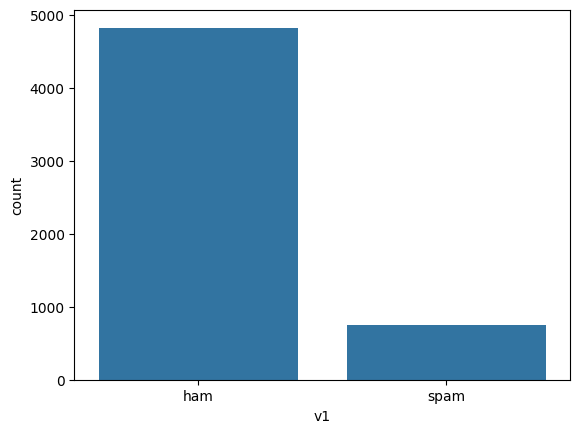

In [4]:
sns.countplot(x='v1', data=data)
plt.show()


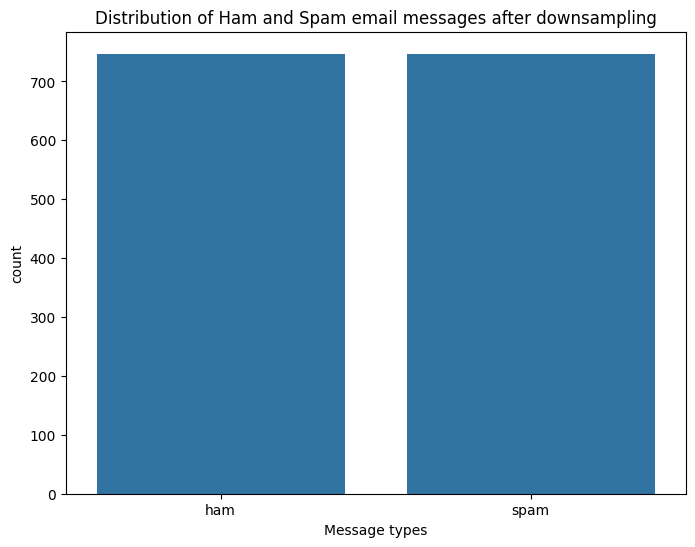

In [5]:
# Downsampling to balance the dataset
ham_msg = data[data.v1 == 'ham']
spam_msg = data[data.v1 == 'spam']
ham_msg = ham_msg.sample(n=len(spam_msg),
						random_state=42)

# Plotting the counts of down sampled dataset
balanced_data = pd.concat([ham_msg, spam_msg], ignore_index=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data,x='v1')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')
plt.show()


In [6]:
balanced_data['v2'] = balanced_data['v2'].str.replace('Subject', '')
balanced_data.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"I am late,so call you tomorrow morning.take ca...",NaN,NaN,NaN
1,ham,U r too much close to my heart. If u go away i...,NaN,NaN,NaN
2,ham,Wait &lt;#&gt; min..,NaN,NaN,NaN
3,ham,Can you call me plz. Your number shows out of ...,NaN,NaN,NaN
4,ham,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...,NaN,NaN,NaN


In [7]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['v2']= balanced_data['v2'].apply(lambda x: remove_punctuations(x))
balanced_data.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,I am lateso call you tomorrow morningtake care...,NaN,NaN,NaN
1,ham,U r too much close to my heart If u go away i ...,NaN,NaN,NaN
2,ham,Wait ltgt min,NaN,NaN,NaN
3,ham,Can you call me plz Your number shows out of c...,NaN,NaN,NaN
4,ham,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...,NaN,NaN,NaN


In [8]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


balanced_data['v2'] = balanced_data['v2'].apply(lambda text: remove_stopwords(text))
balanced_data.head()



,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,lateso call tomorrow morningtake care sweet dr...,NaN,NaN,NaN
1,ham,u r much close heart u go away shattered plz stay,NaN,NaN,NaN
2,ham,wait ltgt min,NaN,NaN,NaN
3,ham,call plz number shows coveragd area urgnt call...,NaN,NaN,NaN
4,ham,maybe woke fucking 3 wouldnt problem,NaN,NaN,NaN


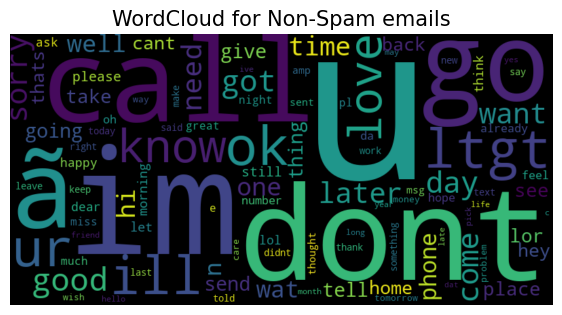

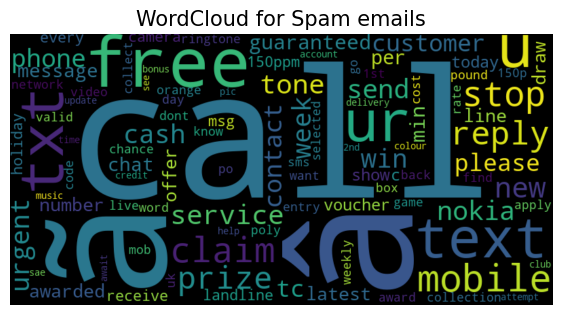

In [9]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['v2'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['v1'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['v1'] == 'spam'], typ='Spam')


In [10]:
# 二分类，把垃圾邮件和非垃圾邮件值变为1和0
# 创建一个映射字典
# balanced_data.head()

# 重新进行映射
mapping_dict = {'ham': 0, 'spam': 1}
balanced_data['v1'] = balanced_data['v1'].map(mapping_dict)

# 打印结果
print(balanced_data)



      v1                                                 v2 Unnamed: 2  \
0      0  lateso call tomorrow morningtake care sweet dr...        NaN   
1      0  u r much close heart u go away shattered plz stay        NaN   
2      0                                      wait ltgt min        NaN   
3      0  call plz number shows coveragd area urgnt call...        NaN   
4      0               maybe woke fucking 3 wouldnt problem        NaN   
...   ..                                                ...        ...   
1489   1  want explicit sex 30 secs ring 02073162414 cos...        NaN   
1490   1  asked 3mobile 0870 chatlines inclu free mins i...        NaN   
1491   1  contract mobile 11 mnths latest motorola nokia...        NaN   
1492   1  reminder o2 get 250 pounds free call credit de...        NaN   
1493   1  2nd time tried 2 contact u u ã¥â£750 pound pri...        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  
1           NaN        NaN  
2           NaN        N

In [11]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['v2'],
													balanced_data['v1'],
													test_size = 0.2,
													random_state = 42)


In [12]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len, 
								padding='post', 
								truncating='post')
test_sequences = pad_sequences(test_sequences, 
							maxlen=max_len, 
							padding='post', 
							truncating='post')


In [13]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
									output_dim=32, 
									input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           130016    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 133729 (522.38 KB)
Trainable params: 133729 (522.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')


In [15]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


In [16]:
# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=20, 
					batch_size=32,
					callbacks = [lr, es]
				)


Epoch 1/20


38/38 [==============================] - 4s 42ms/step - loss: 0.6938 - accuracy: 0.5038 - val_loss: 0.6934 - val_accuracy: 0.4849 - lr: 0.0010
Epoch 2/20
38/38 [==============================] - 1s 26ms/step - loss: 0.6933 - accuracy: 0.5038 - val_loss: 0.6933 - val_accuracy: 0.4849 - lr: 0.0010
Epoch 3/20
38/38 [==============================] - 1s 25ms/step - loss: 0.6933 - accuracy: 0.4870 - val_loss: 0.6932 - val_accuracy: 0.4849 - lr: 0.0010
Epoch 4/20
38/38 [==============================] - 1s 25ms/step - loss: 0.6934 - accuracy: 0.4720 - val_loss: 0.6936 - val_accuracy: 0.4849 - lr: 0.0010


In [17]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


10/10 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.4849
Test Loss : 0.6933786869049072
Test Accuracy : 0.48494982719421387


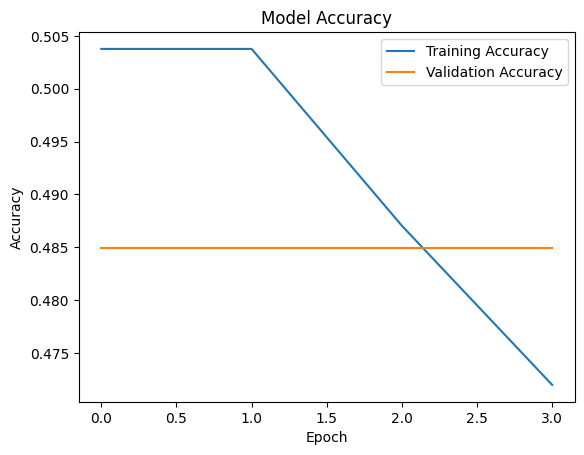

In [18]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
